# Module 2 - Resampling WaPOR climate data (RET & PCP) and calculate Potential ET
This Notebook contains the following steps
* Step a - Import modules/libraries
* Step b - Resampling raster data
* Step c - Calculate seasonal PCP and RET data

**=====================================================================================================================**

![title](https://raw.githubusercontent.com/wateraccounting/WaPORIPA/main/images/Resampling.png)

**=====================================================================================================================**

Before you start running this Notebook, make sure you have the following information:

*   WaPOR Reference ET and PCP for your case study for the period you want to do the analyses. Use this script for downloading the data: [Downloading_WaPORv3_data script](https://github.com/wateraccounting/WaPORMOOC/tree/main/1_WaPOR_download_colab). *For small areas make sure you download the data using a bounding box to avoid non data*

*   Sample of a TIFF file with the resolution you want to do the analyses

## Step a - Import modules/libraries

In [2]:
!pip install --upgrade rioxarray --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 62.0 MB/s eta 0:00:00


In [3]:
import os                             # a module for interacting with the operating system
import glob                           # used to retrieve files/pathnames matching a specified pattern
import matplotlib.pyplot as plt       # is a plotting library used for 2D graphics in python
import numpy as np                    # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rioxr
import rasterio as rio
import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import calendar
import datetime

from osgeo import ogr, gdal
import subprocess


To import some useful GISfunctions, zip the Modules folder from github and upload it here.

In [4]:
#To upload modules.zip (importing GISfunctions to do the calculations).
from google.colab import files
uploaded = files.upload()

Saving Modules.zip to Modules.zip


In [5]:
# unzip the uploaded zipfile
!unzip '/content/Modules.zip' -d '/content/'

Archive:  /content/Modules.zip
   creating: /content/Modules/
   creating: /content/Modules/GIS_functions/
  inflating: /content/Modules/GIS_functions/GIS_function.py  
 extracting: /content/Modules/GIS_functions/__init__.py  
   creating: /content/Modules/GIS_functions/__pycache__/
  inflating: /content/Modules/GIS_functions/__pycache__/GIS_function.cpython-37.pyc  
  inflating: /content/Modules/GIS_functions/__pycache__/__init__.cpython-37.pyc  
   creating: /content/Modules/WaPOR/
  inflating: /content/Modules/WaPOR/GIS_functions.py  
  inflating: /content/Modules/WaPOR/WaitbarConsole.py  
  inflating: /content/Modules/WaPOR/WaporAPI.py  
  inflating: /content/Modules/WaPOR/__init__.py  
  inflating: /content/Modules/WaPOR/__init__.pyc  
   creating: /content/Modules/WaPOR/__pycache__/
  inflating: /content/Modules/WaPOR/__pycache__/AET_dekadal.cpython-36.pyc  
  inflating: /content/Modules/WaPOR/__pycache__/AET_dekadal.cpython-37.pyc  
  inflating: /content/Modules/WaPOR/__pycache_

In [13]:
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "/content/Modules"))
from GIS_functions import GIS_function as gis

Changing directory back to main directory

In [14]:
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "/content"))

# Step b - Resample raster data

After downloading RET and PCP using [Downloading_WaPORv3_data script](https://github.com/wateraccounting/WaPORMOOC/tree/main/1_WaPOR_download_colab), the data needs to be resampled to the same resolution as the NPP and AETI data. You need an example file (TIFF file) with this resolution at hand (if you call the file 'sample_res.tif' the script will run without changing file names).

*Download using bounding box (bb) not shapefile to avoid empty data.*

## Import the input data and sample of resolution

Import downloaded RET and PCP files

In [8]:
#To upload data.zip.
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [9]:

# unzip the uploaded zipfile
!unzip '/content/data.zip' -d '/content/'

Archive:  /content/data.zip
   creating: /content/content/output/
   creating: /content/content/output/L3-NPP-D/
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2023-02-11.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-11-21.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2023-01-21.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-12-01.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-11-11.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-11-01.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2023-04-21.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-10-01.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2023

Import the example file with the required resolution

In [10]:
#To upload sample resolution file.
from google.colab import files
uploaded = files.upload()

Saving sample_res.tif to sample_res.tif


## i) Resample Reference ET

In [40]:

source_file   = '/content/sample_res.tif'                        # Read gdal info of template raster file
target_folder = '/content/content/output/L1-RET-D'               # folder of data to be resampled
target_fhsRET    = glob.glob(target_folder + '/*.tif')

source_file, target_folder, target_fhsRET

('/content/sample_res.tif',
 '/content/content/output/L1-RET-D',
 ['/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-01-21.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-02-21.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2022-12-01.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2022-12-21.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2022-10-21.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-04-01.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-03-21.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2022-10-11.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2022-10-01.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-04-21.tif',
  '/content/content/output/L1-RET-D/bb_L1-RET-D_NONE_dekad_converted_2023-0

## The size and shape of the raster files

In [17]:
## The size and shape of the raster files
template   = gis.OpenAsArray(source_file, nan_values=True)
original   = gis.OpenAsArray(target_fhs[0], nan_values=True)

print ('The size & shape of the template raster      =', template.size,  '&', template.shape)
print ('The size & shape of the data to be resampled =', original.size,  '&', original.shape)

The size & shape of the template raster      = 347133 & (461, 753)
The size & shape of the data to be resampled = 1 & (1, 1)


## Make or connect with the directory the output folder

In [18]:
output_folder = '/content/content/resampled/L1-RET-D_resampled'

## Make one if the folder does not exit
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_folder

'/content/content/resampled/L1-RET-D_resampled'

## Resample raster data

In [19]:
Resample = gis.MatchProjResNDV (source_file, target_fhs, output_folder, resample = 'near', dtype = 'float32')

In [22]:
## Check the size and shape of the resampled raster files
Resampled   = "/content/content/resampled/L1-RET-D_resampled/bb_L1-RET-D_NONE_dekad_converted_2022-10-01.tif"
resampled   = gis.OpenAsArray(Resampled , nan_values=True)

print ('The size & shape of the resampled data =', resampled.size,  '&', resampled.shape)

The size & shape of the resampled data = 347133 & (461, 753)


## ii) Resample Precipitation layers

In [35]:
source_file   = '/content/sample_res.tif'     # Read gdal info of template raster file
target_folder = '/content/content/output/L1-PCP-D'                      # data to be resampled
target_fhsPCP    = glob.glob(target_folder + '/*.tif')

source_file, target_folder, target_fhsPCP

('/content/sample_res.tif',
 '/content/content/output/L1-PCP-D',
 ['/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2023-04-01.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2023-02-01.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2023-03-01.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2022-11-01.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2023-03-21.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2023-01-01.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2023-04-21.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2023-01-11.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2022-11-21.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2022-12-21.tif',
  '/content/content/output/L1-PCP-D/bb_L1-PCP-D_NONE_dekad_converted_2022-1

## The size and shape of the raster files

In [25]:
## The size and shape of the raster files
template   = gis.OpenAsArray(source_file, nan_values=True)
original   = gis.OpenAsArray(target_fhs[0], nan_values=True)

print ('The size & shape of the template raster      =', template.size,  '&', template.shape)
print ('The size & shape of the data to be resampled =', original.size,  '&', original.shape)

The size & shape of the template raster      = 347133 & (461, 753)
The size & shape of the data to be resampled = 8 & (2, 4)


## Make or connect with the directory the output folder

In [26]:
output_folder = '/content/content/resampled/L1-PCP-D_resampled'

## Make one if the folder does not exit
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_folder

'/content/content/resampled/L1-PCP-D_resampled'

## Resample raster data

In [27]:
Resample = gis.MatchProjResNDV (source_file, target_fhs, output_folder, resample = 'near', dtype = 'float32')

In [28]:
## Check the size and shape of the resampled raster files
Resampled   = "/content/content/resampled/L1-PCP-D_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-10-01.tif"
resampled   = gis.OpenAsArray(Resampled , nan_values=True)

print ('The size & shape of the resampled data =', resampled.size,  '&', resampled.shape)

The size & shape of the resampled data = 347133 & (461, 753)


# Step c - Create seasonal climate layers


Create output folders

In [30]:
output_folderSeason = "/content/content/Season"

if not os.path.exists(output_folderSeason):
    os.makedirs(output_folderSeason)
output_folderSeason


'/content/content/Season'

Define seasons

In [31]:
season_periods = {
    'season1': {'SOS': '2022-10-01', 'EOS': '2023-04-30'}
}

###Define function for temporal aggregation

This script defines the function `SumSeason `which is used in the next sections. Using functions in such a way improves the readability and replicability of the scripts and avoids errors. For example we need this function to aggregate AETI and NPP data.

Review this script, main difference compared to the script you used in the previous Notebook is that this script uses the metadata of the files to identify the dates. Disadvantage is that it requires opening and closing of each file and could take time when working with a lot of data. The script also considers part of dekadal values when start or end date is in the middle of the dekad (part of the if-statements).

In [32]:
# summation of raster between two dates
def SumSeason(input_fhs, sowing_date, harvesting_date):

    # add rasters that falls within sowing and harvesting date
    Sums = 0
    for i, in_fh in enumerate(input_fhs):
        # open raster file and get start and end date from attributes
        ds = rioxr.open_rasterio(in_fh)
        ds = ds.where(ds!=ds.attrs['_FillValue'])
        if i == 0:
          attrs = ds.attrs
        raster_startdate = datetime.datetime.strptime(ds.attrs['start_date'], '%Y-%m-%d' ).date()
        raster_enddate   = datetime.datetime.strptime(ds.attrs['end_date'], '%Y-%m-%d' ).date()

        # accumulate full or part of the dekadal value
        if (raster_startdate >= sowing_date) & (raster_enddate <= harvesting_date):
            Sum = ds
            Sums += Sum
#             print ("1",in_fh)

        elif (raster_startdate <sowing_date)&(raster_enddate >sowing_date)&(raster_enddate <harvesting_date):
            Sum = ds
            Sum = Sum*((raster_enddate-sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("2",in_fh)

        elif (raster_startdate >sowing_date)&(raster_startdate <harvesting_date)&(raster_enddate >harvesting_date):
            Sum = ds
            Sum = Sum*((harvesting_date- raster_startdate)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("3",in_fh)

        elif (sowing_date>=raster_startdate)&(harvesting_date<=raster_enddate):
            Sum = ds
            Sum = Sum*((harvesting_date- sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("4",in_fh)
    attrs.update({'start_date':datetime.datetime.strftime(SOS, '%Y-%m-%d'),
              'end_date': datetime.datetime.strftime(EOS, '%Y-%m-%d'),
              'units' : 'mm/season'})
    del attrs['number_of_days']
    del attrs['temporal_resolution']
    del attrs['units_conversion_factor']

    Sums.attrs  = attrs
    return Sums

Calculate seasonal **PCP**

the mean, SD for  2022-10-01/2023-04-30 = 14.4 & 2.8


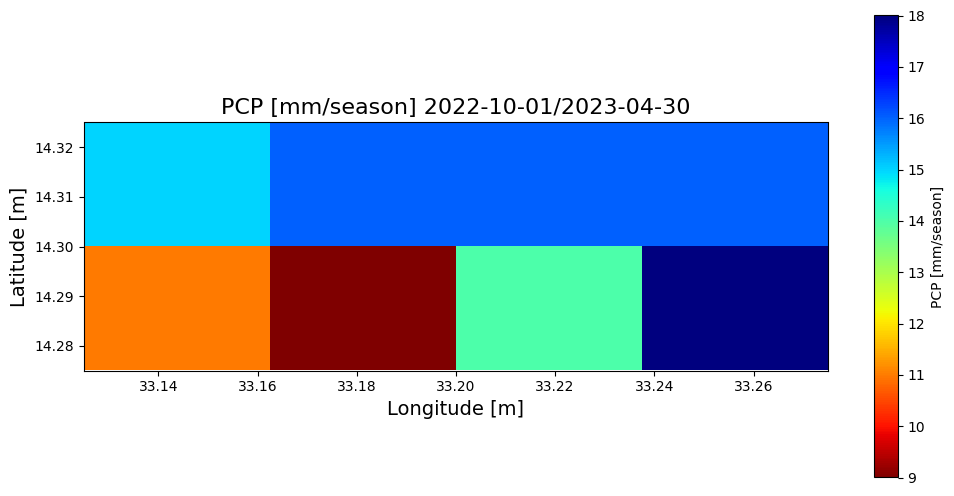

In [37]:
# Assign inputs to the SumSeason function
input_fhs      = target_fhsPCP
output_folder  = output_folderSeason


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'PCP' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='PCP [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('PCP [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

Calculate seasonal **Reference ET**

the mean, SD for  2022-10-01/2023-04-30 = 1678.0 & 0.0


<ipython-input-41-c5a99acf4738>:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
<ipython-input-41-c5a99acf4738>:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)


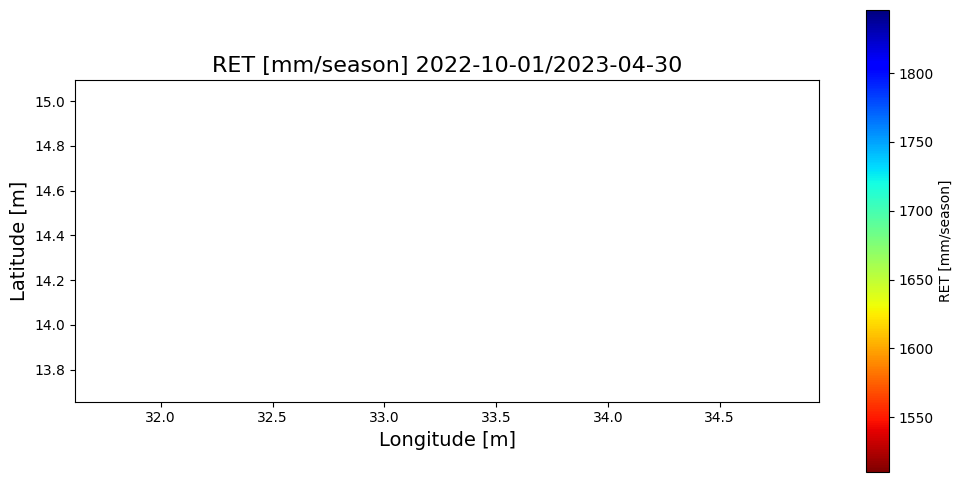

In [41]:
# Assign inputs to the SumSeason function
input_fhs      = target_fhsRET
output_folder  = output_folderSeason


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'RET' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='RET [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('RET [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();